In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt

from loader import All_fundus_files
from networks import weights_init, Discriminator_128_v2_PatchGAN, Flatten

dataroot = "data/fundus2/"
batch_size = 64
image_size = 128 #size using data aug.
num_classes = 5

ch_out = 3 
#ch_noise = 100
#ch_g = 64
ch_d = 64

num_epochs = 500
lr = 0.0002
beta1 = 0.5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
    cudnn.benchmark = True

cuda


In [3]:
# Data
transform_train = transforms.Compose([
    #transforms.RandomResizedCrop(image_size),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.ImageFolder(root=dataroot+'sorted', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

testset = torchvision.datasets.ImageFolder(root=dataroot+'val', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

classes = testset.classes
print(trainset.classes)
print(testset.class_to_idx)
print(len(trainset), len(testset))

['catergory00', 'catergory01', 'catergory02', 'catergory03', 'catergory04']
{'catergory00': 0, 'catergory01': 1, 'catergory02': 2, 'catergory03': 3, 'catergory04': 4}
3462 200


In [4]:
# Model
net = Discriminator_128_v2_PatchGAN(ch_out, ch_d)
net.backbone[14] = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    Flatten(),
    nn.Linear(in_features=ch_d * 16, out_features=num_classes, bias=True)
)
net.pooling = nn.Identity()
net = net.to(device)
net.apply(weights_init)
print(net)

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if True:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/exp6/ckpt2.pth')
    msg = net.load_state_dict(checkpoint['net'], strict=False)
    assert set(msg.missing_keys) == {"backbone.14.2.weight", "backbone.14.2.bias"}, 'missing_keys: {}'.format(set(msg.missing_keys))
    assert set(msg.unexpected_keys) == {"backbone.14.weight"}, 'unexpected_keys: {}'.format(set(msg.unexpected_keys))
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    print(best_acc,start_epoch)
    
    for name, param in net.named_parameters():
        if name not in ["backbone.8.weight","backbone.9.weight","backbone.9.bias","backbone.11.weight", "backbone.12.weight", "backbone.12.bias", "backbone.14.2.weight", "backbone.14.2.bias"]:
            param.requires_grad = False
        else:
            print('{}'.format(name))
    '''
    backbone.0.weight
    backbone.2.weight
    backbone.3.weight
    backbone.3.bias
    backbone.5.weight
    backbone.6.weight
    backbone.6.bias
    backbone.8.weight
    backbone.9.weight
    backbone.9.bias
    backbone.11.weight
    backbone.12.weight
    backbone.12.bias
    backbone.14.2.weight
    backbone.14.2.bias
    '''
    # check
    parameters = list(filter(lambda p: p.requires_grad, net.parameters()))
    assert len(parameters) == 8


# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, lr=lr, betas=(beta1, 0.999))
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [100,250], gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


Discriminator_128_v2_PatchGAN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNo

In [5]:
from torchsummary import summary
summary(net, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 7, 7]       8,388,608
      BatchNorm2d-13           [-1, 1024, 7, 7]           2,048
        LeakyReLU-14           [-1, 102

In [6]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train Loss: %.3f | Acc: %.3f%% (%d/%d)' %(train_loss / (batch_idx+1), 100.*correct/total, correct, total))
    return train_loss /(batch_idx+1), correct/total

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print('Test Loss: %.3f | Acc: %.3f%% (%d/%d)' %(test_loss /(batch_idx+1), 100.*correct/total, correct, total))
    return test_loss /(batch_idx+1), correct/total

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint/exp3'):
            os.mkdir('checkpoint/exp3')
        torch.save(state, './checkpoint/exp3/ckpt.pth')
        best_acc = acc

Train_losses = []
Test_losses = []
Train_acc = []
Test_acc = []
for epoch in range(start_epoch, start_epoch+num_epochs):
    ls, acc = train(epoch)
    Train_losses.append(ls)
    Train_acc.append(acc)
    
    ls, acc = test(epoch)
    Test_losses.append(ls)
    Test_acc.append(acc)
    
    scheduler.step()


Epoch: 100
Train Loss: 0.839 | Acc: 70.364% (2436/3462)
Test Loss: 1.640 | Acc: 39.500% (79/200)

Epoch: 101
Train Loss: 0.753 | Acc: 73.975% (2561/3462)
Test Loss: 1.459 | Acc: 45.000% (90/200)

Epoch: 102
Train Loss: 0.710 | Acc: 74.552% (2581/3462)
Test Loss: 1.585 | Acc: 44.000% (88/200)

Epoch: 103
Train Loss: 0.682 | Acc: 75.101% (2600/3462)
Test Loss: 1.722 | Acc: 46.500% (93/200)

Epoch: 104
Train Loss: 0.692 | Acc: 75.188% (2603/3462)
Test Loss: 1.660 | Acc: 45.000% (90/200)

Epoch: 105
Train Loss: 0.677 | Acc: 75.765% (2623/3462)
Test Loss: 1.514 | Acc: 44.500% (89/200)

Epoch: 106
Train Loss: 0.674 | Acc: 75.361% (2609/3462)
Test Loss: 1.437 | Acc: 44.000% (88/200)

Epoch: 107
Train Loss: 0.658 | Acc: 76.199% (2638/3462)
Test Loss: 1.333 | Acc: 52.000% (104/200)

Epoch: 108
Train Loss: 0.653 | Acc: 76.256% (2640/3462)
Test Loss: 1.475 | Acc: 51.500% (103/200)

Epoch: 109
Train Loss: 0.633 | Acc: 76.285% (2641/3462)
Test Loss: 1.333 | Acc: 51.500% (103/200)

Epoch: 110
Train

Train Loss: 0.444 | Acc: 83.651% (2896/3462)
Test Loss: 1.571 | Acc: 46.000% (92/200)

Epoch: 184
Train Loss: 0.423 | Acc: 83.593% (2894/3462)
Test Loss: 1.251 | Acc: 54.000% (108/200)

Epoch: 185
Train Loss: 0.411 | Acc: 84.287% (2918/3462)
Test Loss: 1.715 | Acc: 53.500% (107/200)

Epoch: 186
Train Loss: 0.441 | Acc: 83.680% (2897/3462)
Test Loss: 1.262 | Acc: 55.500% (111/200)

Epoch: 187
Train Loss: 0.419 | Acc: 83.882% (2904/3462)
Test Loss: 1.633 | Acc: 52.500% (105/200)

Epoch: 188
Train Loss: 0.404 | Acc: 84.489% (2925/3462)
Test Loss: 1.250 | Acc: 53.000% (106/200)

Epoch: 189
Train Loss: 0.393 | Acc: 85.789% (2970/3462)
Test Loss: 1.304 | Acc: 54.500% (109/200)

Epoch: 190
Train Loss: 0.391 | Acc: 84.258% (2917/3462)
Test Loss: 1.346 | Acc: 53.000% (106/200)

Epoch: 191
Train Loss: 0.374 | Acc: 85.529% (2961/3462)
Test Loss: 1.706 | Acc: 48.500% (97/200)

Epoch: 192
Train Loss: 0.382 | Acc: 85.500% (2960/3462)
Test Loss: 1.480 | Acc: 52.000% (104/200)

Epoch: 193
Train Loss: 

Test Loss: 1.437 | Acc: 54.500% (109/200)

Epoch: 267
Train Loss: 0.219 | Acc: 92.461% (3201/3462)
Test Loss: 2.016 | Acc: 52.000% (104/200)

Epoch: 268
Train Loss: 0.232 | Acc: 91.710% (3175/3462)
Test Loss: 2.312 | Acc: 55.000% (110/200)

Epoch: 269
Train Loss: 0.221 | Acc: 91.999% (3185/3462)
Test Loss: 1.535 | Acc: 54.000% (108/200)

Epoch: 270
Train Loss: 0.235 | Acc: 91.334% (3162/3462)
Test Loss: 3.369 | Acc: 51.000% (102/200)

Epoch: 271
Train Loss: 0.274 | Acc: 90.699% (3140/3462)
Test Loss: 3.227 | Acc: 45.500% (91/200)

Epoch: 272
Train Loss: 0.256 | Acc: 90.526% (3134/3462)
Test Loss: 1.574 | Acc: 55.500% (111/200)

Epoch: 273
Train Loss: 0.213 | Acc: 92.634% (3207/3462)
Test Loss: 1.505 | Acc: 50.000% (100/200)

Epoch: 274
Train Loss: 0.227 | Acc: 91.479% (3167/3462)
Test Loss: 1.262 | Acc: 59.000% (118/200)

Epoch: 275
Train Loss: 0.199 | Acc: 92.837% (3214/3462)
Test Loss: 1.969 | Acc: 51.000% (102/200)

Epoch: 276
Train Loss: 0.210 | Acc: 93.125% (3224/3462)
Test Loss: 

Test Loss: 2.327 | Acc: 50.500% (101/200)

Epoch: 350
Train Loss: 0.115 | Acc: 96.389% (3337/3462)
Test Loss: 2.438 | Acc: 55.000% (110/200)

Epoch: 351
Train Loss: 0.110 | Acc: 97.083% (3361/3462)
Test Loss: 2.075 | Acc: 52.500% (105/200)

Epoch: 352
Train Loss: 0.165 | Acc: 95.754% (3315/3462)
Test Loss: 3.284 | Acc: 53.000% (106/200)

Epoch: 353
Train Loss: 0.173 | Acc: 94.685% (3278/3462)
Test Loss: 1.883 | Acc: 58.000% (116/200)

Epoch: 354
Train Loss: 0.139 | Acc: 95.263% (3298/3462)
Test Loss: 1.824 | Acc: 54.500% (109/200)

Epoch: 355
Train Loss: 0.112 | Acc: 96.880% (3354/3462)
Test Loss: 2.716 | Acc: 43.500% (87/200)

Epoch: 356
Train Loss: 0.144 | Acc: 95.350% (3301/3462)
Test Loss: 1.735 | Acc: 54.000% (108/200)

Epoch: 357
Train Loss: 0.122 | Acc: 96.216% (3331/3462)
Test Loss: 2.165 | Acc: 56.000% (112/200)

Epoch: 358
Train Loss: 0.110 | Acc: 96.129% (3328/3462)
Test Loss: 2.052 | Acc: 56.500% (113/200)

Epoch: 359
Train Loss: 0.092 | Acc: 97.314% (3369/3462)
Test Loss: 

Test Loss: 2.017 | Acc: 59.000% (118/200)

Epoch: 433
Train Loss: 0.068 | Acc: 98.238% (3401/3462)
Test Loss: 2.229 | Acc: 57.500% (115/200)

Epoch: 434
Train Loss: 0.077 | Acc: 97.747% (3384/3462)
Test Loss: 2.771 | Acc: 55.000% (110/200)

Epoch: 435
Train Loss: 0.067 | Acc: 98.007% (3393/3462)
Test Loss: 2.207 | Acc: 56.500% (113/200)

Epoch: 436
Train Loss: 0.055 | Acc: 98.527% (3411/3462)
Test Loss: 2.053 | Acc: 59.000% (118/200)

Epoch: 437
Train Loss: 0.057 | Acc: 98.238% (3401/3462)
Test Loss: 2.025 | Acc: 57.500% (115/200)

Epoch: 438
Train Loss: 0.054 | Acc: 98.354% (3405/3462)
Test Loss: 2.141 | Acc: 60.000% (120/200)

Epoch: 439
Train Loss: 0.063 | Acc: 98.209% (3400/3462)
Test Loss: 2.112 | Acc: 58.500% (117/200)

Epoch: 440
Train Loss: 0.055 | Acc: 98.382% (3406/3462)
Test Loss: 2.004 | Acc: 59.000% (118/200)

Epoch: 441
Train Loss: 0.051 | Acc: 98.382% (3406/3462)
Test Loss: 2.021 | Acc: 60.500% (121/200)

Epoch: 442
Train Loss: 0.064 | Acc: 98.498% (3410/3462)
Test Loss:

Test Loss: 2.363 | Acc: 56.500% (113/200)

Epoch: 516
Train Loss: 0.056 | Acc: 98.671% (3416/3462)
Test Loss: 1.992 | Acc: 59.000% (118/200)

Epoch: 517
Train Loss: 0.042 | Acc: 99.047% (3429/3462)
Test Loss: 2.107 | Acc: 59.000% (118/200)

Epoch: 518
Train Loss: 0.049 | Acc: 98.556% (3412/3462)
Test Loss: 2.115 | Acc: 60.000% (120/200)

Epoch: 519
Train Loss: 0.046 | Acc: 98.873% (3423/3462)
Test Loss: 2.193 | Acc: 59.500% (119/200)

Epoch: 520
Train Loss: 0.038 | Acc: 98.845% (3422/3462)
Test Loss: 2.175 | Acc: 60.500% (121/200)

Epoch: 521
Train Loss: 0.035 | Acc: 98.960% (3426/3462)
Test Loss: 2.254 | Acc: 59.500% (119/200)

Epoch: 522
Train Loss: 0.038 | Acc: 99.162% (3433/3462)
Test Loss: 2.158 | Acc: 60.500% (121/200)

Epoch: 523
Train Loss: 0.035 | Acc: 98.873% (3423/3462)
Test Loss: 2.034 | Acc: 60.000% (120/200)

Epoch: 524
Train Loss: 0.040 | Acc: 98.931% (3425/3462)
Test Loss: 2.382 | Acc: 58.500% (117/200)

Epoch: 525
Train Loss: 0.040 | Acc: 98.614% (3414/3462)
Test Loss:

Test Loss: 2.277 | Acc: 60.000% (120/200)

Epoch: 599
Train Loss: 0.031 | Acc: 98.931% (3425/3462)
Test Loss: 2.196 | Acc: 60.000% (120/200)


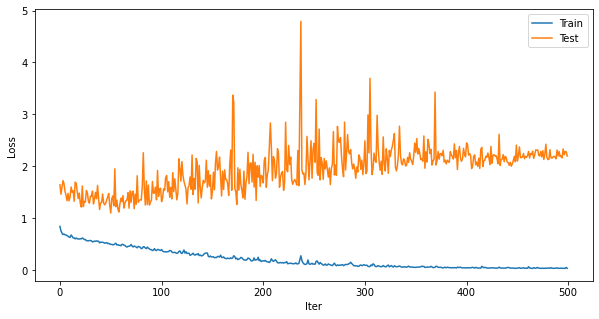

In [7]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(Train_losses,label="Train")
plt.plot(Test_losses,label="Test")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

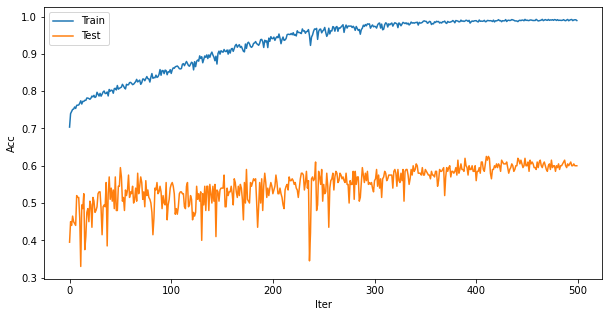

In [8]:
# check acc
plt.figure(figsize=(10,5))
plt.plot(Train_acc,label="Train")
plt.plot(Test_acc,label="Test")
plt.xlabel("Iter")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [9]:
def test_only():
    net.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))
    return (100 * correct / total)

acc = test_only() 

Accuracy of the network on the 10000 test images: 60.000000 %


In [10]:
def test_each_class():
    net.eval()
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    #label = int(label.cpu().numpy())
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.2f} %".format(classname,
        accuracy))

test_each_class()

Accuracy for class catergory00 is: 95.00 %
Accuracy for class catergory01 is: 62.50 %
Accuracy for class catergory02 is: 77.50 %
Accuracy for class catergory03 is: 35.00 %
Accuracy for class catergory04 is: 30.00 %


In [ ]:
# save
state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
#torch.save(state, './checkpoint/ckpt_fin.pth')

In [ ]:
# load
resume = 'ckpt'
checkpoint = torch.load('./checkpoint/'+resume+'.pth')
#net.load_state_dict(checkpoint['net'])

In [ ]:
acc = test_only() 
test_each_class()